# Determining the cost of cars

Service for the sale of used cars "Not beaten, not beautiful" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. At your disposal are historical data: technical specifications, equipment and prices of cars. You need to build a model to determine the cost.

The customer is important:

- quality of prediction;
- prediction speed;
- studying time.

# 1. Data preparation

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<AxesSubplot:>

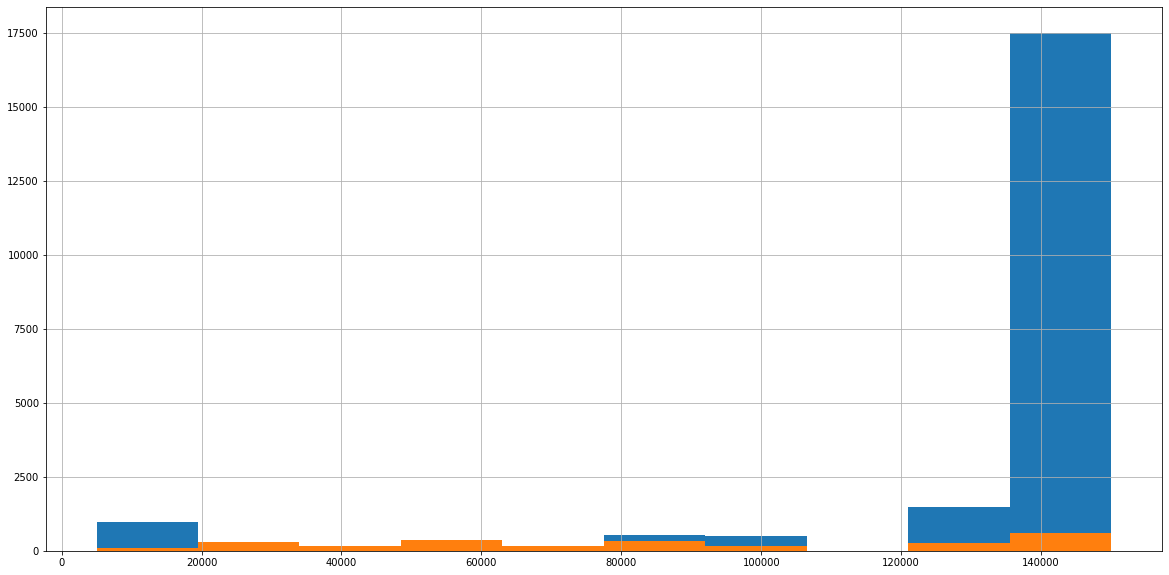

In [3]:
#data['Price'].hist(bins=50, figsize=(20, 10))
g = data.query(' Price > 19000')
b = data.query('100 <Price < 500')
b['Kilometer'].hist( figsize=(20, 10))
g['Kilometer'].hist( figsize=(20, 10))
#g.head(50)

In [4]:
data['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [5]:
71154/354369

0.20079070121822168

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
# Removing columns not needed for training
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

# Delete rows where there are null values
data = data.loc[data.ne(0).all(axis=1)]

# Replacing nan with ink (i do't know)
data['VehicleType'] = data['VehicleType'].fillna('idk')
data['Gearbox'] = data['Gearbox'].fillna('idk')
data['Model'] = data['Model'].fillna('idk')
data['FuelType'] = data['FuelType'].fillna('idk')
data['NotRepaired'] = data['NotRepaired'].fillna('idk')

# Remove columns with abnormal values
#(in 1886 the first machine appeared, the most powerful machine was 1300, and the weakest was 5)
# You can hardly buy a car cheaper than 100 euros
data = data.query(' RegistrationYear <= 2016 and RegistrationYear >= 1886')
data = data.query(' Price >= 100')
data = data.query(' Power >= 5 and Power <= 1300')

# create a new encoding list
data_rep = data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]

# encoding
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_rep),
                            columns=data_rep.columns)


In [8]:
data = data.reset_index(drop=True)

removed null values

In [9]:
data_ordinal[['Price', 'RegistrationYear', 'Power', 'Kilometer']] = data[['Price', 'RegistrationYear', 'Power', 'Kilometer']]

*Replacing the value from the main dataframe with encoded ones*

In [10]:
data = data_ordinal
data

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Price,RegistrationYear,Power,Kilometer
0,2.0,2.0,121.0,2.0,1.0,2.0,18300,2011,190,125000
1,7.0,0.0,117.0,2.0,14.0,0.0,9800,2004,163,125000
2,6.0,2.0,116.0,7.0,38.0,1.0,1500,2001,75,150000
3,6.0,2.0,101.0,2.0,31.0,1.0,3600,2008,69,90000
4,5.0,2.0,11.0,7.0,2.0,2.0,650,1995,102,150000
...,...,...,...,...,...,...,...,...,...,...
295437,3.0,0.0,4.0,4.0,0.0,1.0,5250,2016,150,150000
295438,5.0,2.0,141.0,7.0,30.0,2.0,3200,2004,225,150000
295439,1.0,0.0,106.0,7.0,32.0,1.0,1199,2000,101,125000
295440,0.0,2.0,224.0,2.0,38.0,1.0,9200,1996,102,150000


**I prepared the data by deleting unnecessary columns, deleted columns with values of 0. Replaced the nan values in the columns 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired' with IDK. Also did the framing**

# 2 Train Models

In [11]:
data_new = data.astype(int)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295442 entries, 0 to 295441
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       295442 non-null  float64
 1   Gearbox           295442 non-null  float64
 2   Model             295442 non-null  float64
 3   FuelType          295442 non-null  float64
 4   Brand             295442 non-null  float64
 5   NotRepaired       295442 non-null  float64
 6   Price             295442 non-null  int64  
 7   RegistrationYear  295442 non-null  int64  
 8   Power             295442 non-null  int64  
 9   Kilometer         295442 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 22.5 MB


In [12]:
train, valid, test = np.split(data_new.sample(frac=1, random_state=12345),
                                 [int(.6*len(data_new)), int(.8*len(data_new))])

# variables for features and target feature
features_train = train.drop(['Price'], axis=1)
target_train = train['Price']

features_valid = valid.drop(['Price'], axis=1)
target_valid = valid['Price'] 

features_test = test.drop(['Price'], axis=1)
target_test = test['Price']
print(train.shape)
print(valid.shape)
print(test.shape)

(177265, 10)
(59088, 10)
(59089, 10)


In [13]:
%%time
model = LinearRegression()
model.fit(features_train, target_train) 
predictions_valid = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_valid)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)


MSE: 9800778.366969846
RMSE: 3130.6194861352674
CPU times: user 62.5 ms, sys: 127 ms, total: 189 ms
Wall time: 183 ms


In [14]:
%%time

model1 = CatBoostRegressor(iterations=200, learning_rate=0.5, depth = 10)
# Fit model
model1.fit(features_train, target_train, verbose=10) 
predictions_valid1 = model1.predict(features_valid)
mse1 = mean_squared_error(target_valid, predictions_valid1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

0:	learn: 3076.1139607	total: 103ms	remaining: 20.6s
10:	learn: 1751.9780313	total: 581ms	remaining: 9.98s
20:	learn: 1657.5196840	total: 1.07s	remaining: 9.16s
30:	learn: 1594.3321706	total: 1.56s	remaining: 8.51s
40:	learn: 1548.8638556	total: 2.04s	remaining: 7.91s
50:	learn: 1519.8913027	total: 2.52s	remaining: 7.38s
60:	learn: 1494.6298220	total: 2.99s	remaining: 6.82s
70:	learn: 1471.5661735	total: 3.46s	remaining: 6.29s
80:	learn: 1451.4677742	total: 3.94s	remaining: 5.78s
90:	learn: 1434.8538719	total: 4.44s	remaining: 5.32s
100:	learn: 1418.0692511	total: 4.93s	remaining: 4.84s
110:	learn: 1401.5125383	total: 5.47s	remaining: 4.38s
120:	learn: 1386.3133687	total: 5.95s	remaining: 3.88s
130:	learn: 1374.6169174	total: 6.42s	remaining: 3.38s
140:	learn: 1364.1013676	total: 6.9s	remaining: 2.89s
150:	learn: 1353.5008571	total: 7.37s	remaining: 2.39s
160:	learn: 1342.4949653	total: 7.86s	remaining: 1.9s
170:	learn: 1333.4467978	total: 8.32s	remaining: 1.41s
180:	learn: 1324.436470

In [15]:
%%time
train=lgb.Dataset(features_train, label=target_train)

params={}
params['learning_rate']=1
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='regression'#regression task
params['n_estimators']=200
params['max_depth']= 10

model2=lgb.train(params,train,  10)

predictions_valid2=model2.predict(features_valid)

mse2 = mean_squared_error(target_valid, predictions_valid2)
print("MSE:", mse2)
rmse2 = mse2 ** 0.5 
print("RMSE:", rmse2)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 177265, number of used features: 9
[LightGBM] [Info] Start training from score 4847.856497
MSE: 2748948.3696521693
RMSE: 1657.9952863781516
CPU times: user 15.3 s, sys: 6.73 ms, total: 15.3 s
Wall time: 15.4 s


In [16]:
%%time
model3 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 100)

model3.fit(features_train, target_train)

predictions_valid3 = model3.predict(features_valid)

mse3 = mean_squared_error(target_valid, predictions_valid3)
print("MSE:", mse3)
rmse3 = mse3 ** 0.5 
print("RMSE:", rmse3)

[01:39:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 3130126.0697207
RMSE: 1769.2162303462796
CPU times: user 26.3 s, sys: 150 ms, total: 26.4 s
Wall time: 26.7 s


**The fastest learning model is LightGBM. This model also has a pretty good quality metric**

# 3. Model analysis

In [17]:
%%time
predictions_test = model.predict(features_test)
mse = mean_squared_error(target_test, predictions_test)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)

MSE: 9568856.980723497
RMSE: 3093.3569113058225
CPU times: user 0 ns, sys: 53 ms, total: 53 ms
Wall time: 86 ms


In [18]:
%%time
predictions_test1 = model1.predict(features_test)
mse1 = mean_squared_error(target_test, predictions_test1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

MSE: 2487686.340832145
RMSE: 1577.2401024676442
CPU times: user 53.1 ms, sys: 124 µs, total: 53.3 ms
Wall time: 52.2 ms


In [19]:
%%time
predictions_test2 = model2.predict(features_test)
mse2 = mean_squared_error(target_test, predictions_test2)
print("MSE:", mse2)
rmse2 = mse2 ** 0.5 
print("RMSE:", rmse2)

MSE: 2755567.4626494194
RMSE: 1659.9901995642683
CPU times: user 622 ms, sys: 5.62 ms, total: 628 ms
Wall time: 634 ms


In [20]:
%%time
predictions_test3 = model3.predict(features_test)
mse3 = mean_squared_error(target_test, predictions_test3)
print("MSE:", mse3)
rmse3 = mse3 ** 0.5 
print("RMSE:", rmse3)

MSE: 3234283.763946246
RMSE: 1798.4114556870031
CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 106 ms


**The fastest model turned out to be linear regression, but the problem is that the quality of this model is almost 2 times worse than the others. And since the customer needs speed and quality, the CatBoost model is the best option.**

In [21]:
%%time
model4 = RandomForestRegressor(n_estimators=100, max_depth = 20)
model4.fit(features_train, target_train) 
predictions_valid4 = model4.predict(features_valid)
mse4 = mean_squared_error(target_valid, predictions_valid4)
print("MSE:", mse)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 9568856.980723497
RMSE: 1593.07317421052
CPU times: user 38.7 s, sys: 399 ms, total: 39.1 s
Wall time: 39.1 s


In [22]:
%%time
predictions_test4 = model4.predict(features_test)
mse4 = mean_squared_error(target_test, predictions_test4)
print("MSE:", mse4)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 2512535.04241366
RMSE: 1585.0978021603778
CPU times: user 1.81 s, sys: 8.9 ms, total: 1.82 s
Wall time: 1.83 s


In [23]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

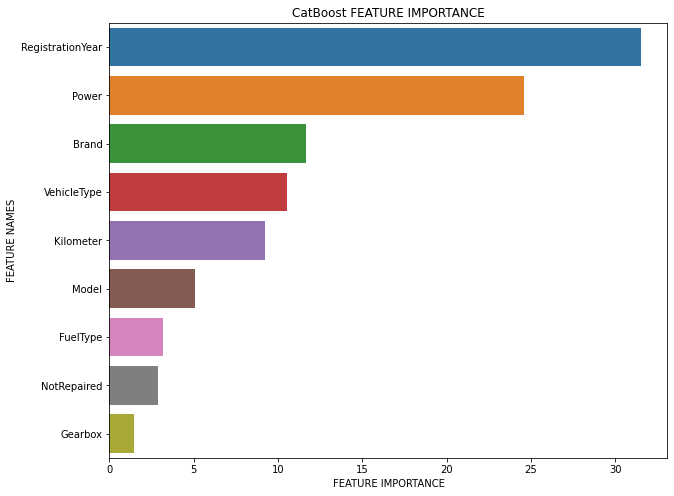

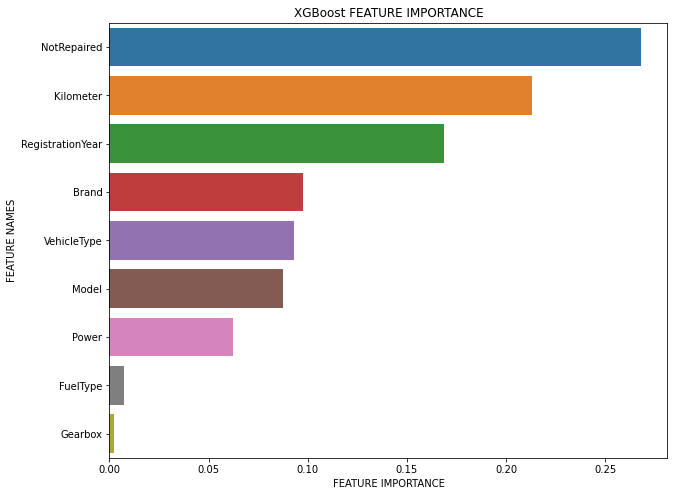

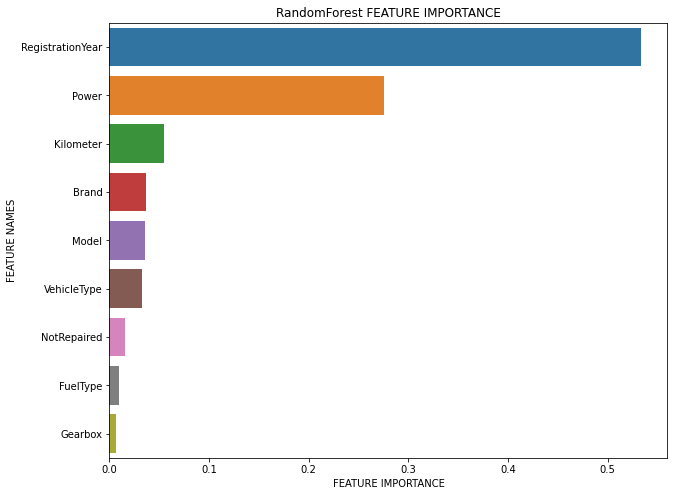

In [24]:
plot_feature_importance(model1.feature_importances_,features_train.columns,'CatBoost ')
plot_feature_importance(model3.feature_importances_,features_train.columns,'XGBoost ')
plot_feature_importance(model4.feature_importances_,features_train.columns,'RandomForest ')

<font color='blue'>Cometary</font> The main factor is the year of registration<br/>

# 4 Conclusion
**We can conclude that the CatBoost model is the most suitable for the customer. It is the fastest and highest quality, but if he needs to constantly retrain it, the LightGBM model will be the best choice. There is also a simple linear regression. It is very fast, but the result is very poor. According to the results, the models are very similar if they are given the same hyperparameters.**

| Params/Model | Linear Regression | catboost | LightGBM | XGBoost | Random Forest |
| :------------ | :-------------: |:-------------: |:-------------: |:- ------------: |:---------------------: |
| Study Time | 44ms | 48.2s | 50.2s | 9.95s| 44.7s|
| Run time | 7.97ms |210ms | 1.29s | 446ms | 1.02s |
| | | | | | |
| Quality on Training Set (RMSE) | 3751.1 |1611.3 | 1717.8 | 1764.6 | 1899.1|
| Quality on test set (RMSE) | 3834.2 |1586 |1695.9| 1754.8|1910.2 |